*Long-term benefits of nonpharmaceutical interventions for endemic infections are shaped by respiratory pathogen dynamics*

Rachel E. Baker, Chadi M. Saad-Roy, Sang Woo Park, Jeremy Farrar, C. Jessica E. Metcalf, and Bryan T. Grenfell


The authors start asking the effect of NPIs efforts applied during the 2020 and ongoing (2023 now) SARS2 pandemic in respiratory infections. They use influenza and RSV as contrasting pathogens with low and high basic reproductive number $R_0$ respectively and with rapid immune escape (SIRS dynamics) and completely immunizing (SIR dynamics).

In [51]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, LinearInterpolation
from jax import grad, jit, vmap
import jax.numpy as np

import matplotlib.pyplot as plt


In [121]:

def influenza_model(t, x, R0, args=None):
    s, i, r = x

    L = 40 # Duration of immunity - weeks
    D = 1  # Duration of infectiousness - week
    μ = 1 / (50 * 52) # Birth/death rate - 1 / (years * weeks)
    N = 1  # Population size

    β = R0 * D
    λ = β * i / N

    sdot = r / L + μ * (N - s) - λ * s
    idot = λ * s - i / D - μ * i
    rdot = i / D - r / L - μ * r

    return np.array([sdot, idot, rdot])


qsim  = lambda wk: np.maximum((0.006/2) * np.sin(2*np.pi*wk/52 + 10.5) + 0.006, 0) # authors absolute humidity
R0min = 1.2
R0max = 3

num_years = 21
t_max     = 52 * num_years      # simulate for 10 years
tsim      = np.arange(0, t_max+1) # list of weeks to simulate

rnot      = np.exp(-180 * qsim(tsim) + np.log(R0max - R0min)) + R0min
R0        = LinearInterpolation(ts=tsim, ys=rnot)

model  = lambda t, x, args: influenza_model(t, x, R0.evaluate(t))
saveat = SaveAt(ts=tsim)

term   = ODETerm(model)
solver = Dopri5()

y0       = np.array([0.19, 0.01, 0.8])
solution = diffeqsolve(term, solver, t0=0, t1=t_max, saveat=saveat, dt0=1, y0=y0)


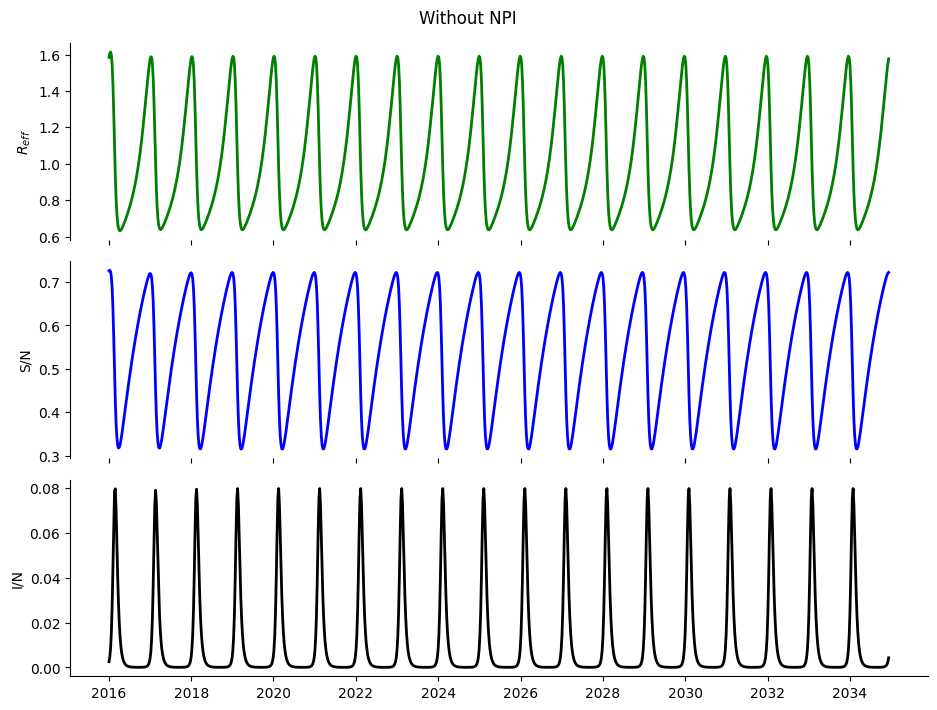

In [138]:
import pandas as pd

s, i, r  = solution.ys[52*2:, :].T
time_sim = solution.ts[52*2:]

dates = pd.date_range(start='2016-01-01', periods=len(time_sim), freq='W')

reff = R0.evaluate(time_sim) * s

fig, ax = plt.subplots(3, 1, figsize=(9.5, 7.2), sharex=True)
ax[0].plot(dates, reff, label=r'$R_{eff}$', color='g', lw=2)
ax[1].plot(dates, s, label='I', color='blue', lw=2)
ax[2].plot(dates, i, label='I', color='k', lw=2)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.spines['bottom'].set_visible(False)

ax[-1].spines['bottom'].set_visible(True)
ax[0].set_ylabel(r"$R_{{eff}}$")
ax[1].set_ylabel(r"S/N")
ax[2].set_ylabel(r"I/N")

plt.suptitle("Without NPI")
plt.tight_layout()



In [156]:
# adding NPIs


num_years = 21
t_max     = 52 * num_years      # simulate for 10 years
tsim      = np.arange(0, t_max+1) # list of weeks to simulate

rnot      = np.exp(-180 * qsim(tsim) + np.log(R0max - R0min)) + R0min


# first set of NPIs
npi_start   = 52 * 6 + 11
npi_end     = 52 * 6 + 11 + 52
betachange  = 0.8
rnot        = rnot.at[npi_start:npi_end].set(rnot[npi_start:npi_end] * betachange)


# second set of NPIs
npi_start   = 52 * 6 + 11 + 104
npi_end     = 52 * 6 + 11 + 33 + 52
betachange  = 0.8
rnot        = rnot.at[npi_start::].set(rnot[npi_start::] * betachange)


R0        = LinearInterpolation(ts=tsim, ys=rnot)

model  = lambda t, x, args: influenza_model(t, x, R0.evaluate(t))
saveat = SaveAt(ts=tsim)

term   = ODETerm(model)
solver = Dopri5()

y0       = np.array([0.19, 0.01, 0.8])
solution = diffeqsolve(term, solver, t0=0, t1=t_max, saveat=saveat, dt0=1, y0=y0)

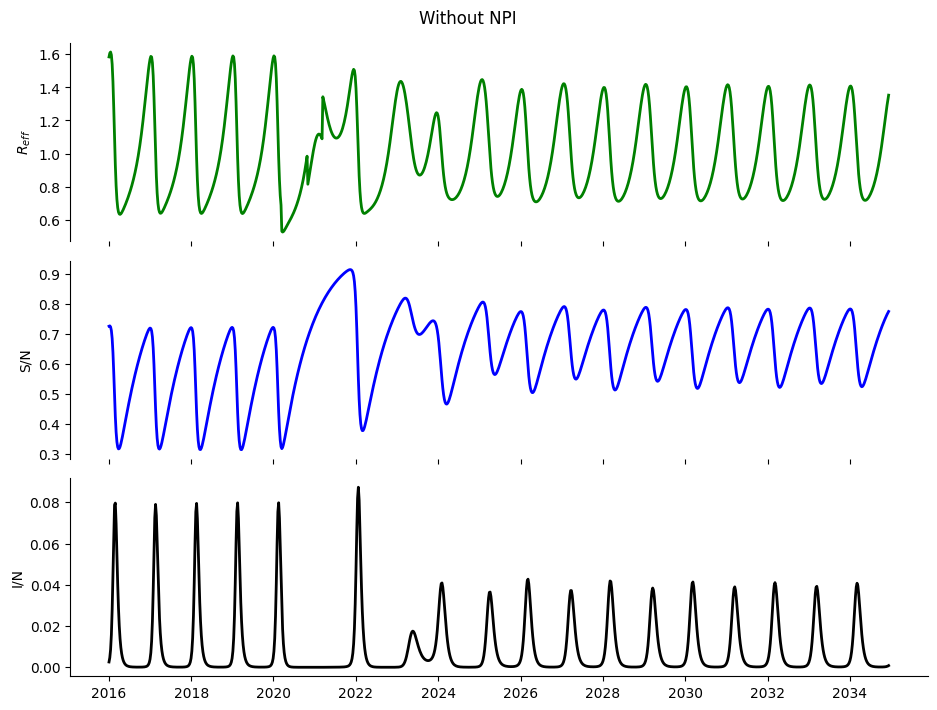

In [157]:
import pandas as pd

s, i, r  = solution.ys[52*2:, :].T
time_sim = solution.ts[52*2:]

dates = pd.date_range(start='2016-01-01', periods=len(time_sim), freq='W')

reff = R0.evaluate(time_sim) * s

fig, ax = plt.subplots(3, 1, figsize=(9.5, 7.2), sharex=True)
ax[0].plot(dates, reff, label=r'$R_{eff}$', color='g', lw=2)
ax[1].plot(dates, s, label='I', color='blue', lw=2)
ax[2].plot(dates, i, label='I', color='k', lw=2)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.spines['bottom'].set_visible(False)

ax[-1].spines['bottom'].set_visible(True)
ax[0].set_ylabel(r"$R_{{eff}}$")
ax[1].set_ylabel(r"S/N")
ax[2].set_ylabel(r"I/N")

plt.suptitle("Without NPI")
plt.tight_layout()


In [26]:

def sirs(x, t, p):
    s, i, r = x

    β = p["beta"]
    γ = p["gamma"]
    ω = p["omega"]
    μ = p["mu"]
    N = p["N"]

    λ = β * i / N

    births  = μ * N
    s2death = μ * s
    i2death = μ * i
    r2death = μ * r

    s2i = λ * s
    i2r = γ * i
    r2s = ω * r

    sdot = -s2i + r2s - s2death + births
    idot = s2i  - i2r - i2death
    rdot = i2r  - r2s - r2death

    return np.array([sdot, idot, rdot])
